# Reddit Climate Change - Visualization of results

Supervision: Prof. Dr. Jan Fabian Ehmke

Group members: Britz Luis, Huber Anja, Krause Felix Elias, Preda Yvonne-Nadine

Time: Summer term 2023 

Data: https://www.kaggle.com/datasets/pavellexyr/the-reddit-climate-change-dataset

In [1]:
import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import matplotlib.colors as pltc

In [2]:
# Corporate Design
plt.rc('font', size=14)
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["font.family"] = "Arial"
cmap = pltc.LinearSegmentedColormap.from_list("", ["#01353B", "#8AE3ED"])
custom_colors = ["#e41a1c", "#9467bd", "#ff7f00", "#bcbd22", "#f781bf", "#e15759", "#b25f30", "#af7aa1", "#7f7f7f", "#8c564b", "#31b831", "#ff9da7"]
color = "#006871"

## Load data and some final processing

In [3]:
df = pd.read_csv("data/comments_final_labels.csv", header=0, index_col=0)
df.shape

(1034318, 16)

In [4]:
# Remove posts with "political climate", if they do not also contain "climate change"
def custom_filter(text):
    if "political climate" in text and "climate change" not in text:
        return False
    return True

df = df[df.body_clean_full.apply(custom_filter)]
df.shape

(1034318, 16)

In [5]:
# discretize sentiment score
std_sentiment = df.sentiment.std()

def sentiment_discretizer(value):
    if value < - std_sentiment:
        return "negative"
    elif value > std_sentiment:
        return "positive"
    return "neutral"

df["sentiment_binary"] = df.sentiment.apply(sentiment_discretizer)

In [6]:
# get charcter count of text
df["character_count"] = df.body_clean_full.apply(len)

In [7]:
df.head(3)

,id,sentiment,score,created_date,created_day,created_month,created_year,topic_number,topic_name,topic_most_used_words,body_clean_full,climate_stance,emotion_small,emotion_large,sentiment_binary,character_count
0,c0i14fb,0.7998,1.0,2010-01-01,1,1,2010,-1,-1_climate_people_global_warming,climate - people - global - warming - just - s...,"should be ""San Diego Weatherman has an opinion...",favor,surprise,NaN,positive,603
1,c0i195b,0.4754,0.0,2010-01-01,1,1,2010,0,0_people_just_climate_global,people - just - climate - global - don - like ...,Both Iggy and Harper would have marched us int...,favor,fear,neutral,neutral,216
2,c0i1a0w,0.0242,1.0,2010-01-01,1,1,2010,0,0_people_just_climate_global,people - just - climate - global - don - like ...,"A man who though a moderate Tory , has a mixed...",favor,surprise,approval,neutral,218


## Topic Analysis per year

In [774]:
year = 2022

In [775]:
# Subset of year
df_year = df[df.created_year == year]

# get topics and counts
topics = df_year.groupby(by="topic_name").id.count().sort_values(ascending=False)
words = df_year.groupby(by="topic_most_used_words").id.count().sort_values(ascending=False)
topics_df = pd.DataFrame({"count": topics, "relative": (topics/df_year.shape[0]*100).round(2)}, index=topics.index)
pprint.pprint(topics_df)

# get top 5 topics and counts
top5_topics = df_year.groupby(by="topic_name").id.count().sort_values(ascending=False).iloc[1:6]
top5_topics_df = pd.DataFrame({"count": top5_topics, "relative": (top5_topics/df_year.shape[0]*100).round(2)}, index=top5_topics.index)

# keep only top 5 topics
df_year = df_year[[True if i in top5_topics.index else False for i in df_year.topic_name]]
pprint.pprint(top5_topics_df)


# sample pro jahr 

                                          count  relative
topic_name                                               
-1_people_just_like_climate               49262     49.92
0_people_like_just_don                    38125     38.63
1_protest_protests_protesting_protesters   1185      1.20
2_god_church_religion_bible                 698      0.71
3_plastic_recycling_plastics_straws         593      0.60
...                                         ...       ...
98_apple_usb_charger_phone                   18      0.02
99_crichton_michael_fear_japanese            17      0.02
100_myth_warroom_librul_upvote               16      0.02
101_shower_hygiene_deodorant_shampoo         16      0.02
102_vaccine_vaccines_mumbo_says              15      0.02

[104 rows x 2 columns]
                                          count  relative
topic_name                                               
0_people_like_just_don                    38125     38.63
1_protest_protests_protesting_protesters   1185 

In [776]:
# Most positive/negative topics per year
results1 = pd.DataFrame(df_year.groupby(by=["topic_name"])["sentiment"].mean())
results1.sort_values(by="sentiment", ascending=False).iloc[[0,-1],:] # Get most pos and most neg topics

,sentiment
topic_name,
2_god_church_religion_bible,0.029834
1_protest_protests_protesting_protesters,-0.279867


In [777]:
# Mean character length
results2 = df_year.groupby(by="topic_name").character_count.mean().round().astype(int)
results2

topic_name
0_people_like_just_don                       698
1_protest_protests_protesting_protesters     540
2_god_church_religion_bible                 1006
3_plastic_recycling_plastics_straws          532
4_trans_gender_women_men                     964
Name: character_count, dtype: int32

In [778]:
# Most frequent label per topic
results_dict = {}
for label in ["emotion_small", "emotion_large", "climate_stance", "sentiment_binary"]:
    if label != "sentiment_binary":
        df_year_temp = df_year[df_year[label] != "neutral"] # exclude neutral as always mode
    else:
        df_year_temp = df_year
    results3 = df_year_temp.groupby(by=["topic_name"])[label].apply(lambda x: x.mode())
    results_dict.update({label: results3})

# Add results from sentiment
descr_results_df = pd.DataFrame.from_dict(results_dict)
descr_results_df = descr_results_df.merge(results1, right_index=True, left_on="topic_name")
descr_results_df = descr_results_df.merge(results2, right_index=True, left_on="topic_name")
descr_results_df = descr_results_df.merge(top5_topics_df, right_index=True, left_on="topic_name")

# Collected results
descr_results_df.columns = ['emotion_small', 'emotion_large', 'climate_stance', 'sentiment_binary',
       'sentiment', 'mean_characters_used', 'number_comments', 'relative']
descr_results_df

emotion_small emotion_large  \
topic_name                                                               
0_people_like_just_don                   0         anger      approval   
                                         1           NaN   realization   
1_protest_protests_protesting_protesters 0         anger         anger   
2_god_church_religion_bible              0         anger   realization   
3_plastic_recycling_plastics_straws      0       disgust      approval   
4_trans_gender_women_men                 0         anger      approval   

                                           climate_stance sentiment_binary  \
topic_name                                                                   
0_people_like_just_don                   0          favor          neutral   
                                         1            NaN              NaN   
1_protest_protests_protesting_protesters 0          favor          neutral   
2_god_church_religion_bible              0          favor          neutral   
3_plastic_recycling_plastics_straws      0          favor          neutral   
4_trans_gender_women_men                 0          favor          neutral   

                                            sentiment  mean_characters_used  \
topic_name                                                                    
0_people_like_just_don                   0   0.002269                   698   
                                         1   0.002269                   698   
1_protest_protests_protesting_protesters 0  -0.279867                   540   
2_god_church_religion_bible              0   0.029834                  1006   
3_plastic_recycling_plastics_straws      0  -0.074602                   532   
4_trans_gender_women_men                 0  -0.086159                   964   

                                            number_comments  relative  
topic_name                                                             
0_people_like_just_don                   0            38125     38.63  
                                         1            38125     38.63  
1_protest_protests_protesting_protesters 0             1185      1.20  
2_god_church_religion_bible              0              698      0.71  
3_plastic_recycling_plastics_straws      0              593      0.60  
4_trans_gender_women_men                 0              560      0.57

## Check out some comments

In [823]:
topic_idx = 2
df_year = df_year.sample(frac = 1)

custom_iterator = iter(df_year[(df_year.topic_number == topic_idx)].to_numpy())

In [824]:
df_year.head(3)

,id,sentiment,score,created_date,created_day,created_month,created_year,topic_number,topic_name,topic_most_used_words,body_clean_full,climate_stance,emotion_small,emotion_large,sentiment_binary,character_count
1035421,ikpwkex,-0.9773,-1.0,2022-08-17,17,8,2022,0,0_people_like_just_don,people - like - just - don - think - world - w...,They were absolute monsters but the USA takes ...,favor,disgust,anger,negative,525
997538,ia9hlf5,0.3875,2.0,2022-05-28,28,5,2022,0,0_people_like_just_don,people - like - just - don - think - world - w...,The petrostates in the past recognized the nee...,favor,fear,realization,neutral,169
959945,hws7m4y,-0.9520,7.0,2022-02-13,13,2,2022,0,0_people_like_just_don,people - like - just - don - think - world - w...,;Has Dice been overun by Post Modern Neo Marxi...,none,surprise,anger,negative,399


In [825]:
curr = next(custom_iterator)
print(curr[0])
print(curr[9])
pprint.pprint(curr[10])
# 2013, topic 0, nr. 4

i32vkpm
god - church - religion - bible - religious - christian - christians - jesus - believe - christianity
('If anything, the earth should start moving a bit away from the sun to offset '
 "the climate change effect. Where is god when you need one? Nowhere, coz it's "
 'a big fat, lethal, corrupting lie.')


In [836]:
curr = next(custom_iterator)
print(curr[0])
pprint.pprint(curr[10])

imh56kd
("We need to make them think climate change is god's punishment for being "
 "wasteful, like how he created aids to punish homosexuality. Like, there's "
 'got to be a way to weaponize their  nd grader logic to our advantage. It '
 "shouldn't be this hard to trick willfully stupid people")


In [783]:
curr = next(custom_iterator)
print(curr[0])
pprint.pprint(curr[10])

imikh6d
('Men spend a LOT of time problem solving. It is what we are hardwired to do. '
 'When you complain to me about something “just to be heard,” my response is '
 'likely to be based on how to solve your issue. That doesn’t mean we don’t '
 'listen. We just approach problems differently. We are frequently solving '
 'problems in our heads. It could be ways to stop world hunger. How to solve '
 'the global climate change which is going to kill us all. But most likely it '
 'is “what would I do if a bear started chasing me down the driveway?” Those '
 'fuckers can move!')


In [784]:
curr = next(custom_iterator)
print(curr[0])
pprint.pprint(curr[10])

i8ncn73
("Since when has climate change and women's rights been staples for "
 'conservative politics?')


In [793]:
curr = next(custom_iterator)
print(curr[0])
pprint.pprint(curr[10])

hspqw9o
('I think it’s a bit unfair to call yourself a mutant, most neurotypical '
 'people can’t write as well as you can.  Also, do you count climate change as '
 'one of the problems caused by activists, or is that an exception?')


## Category distribution over time

In [8]:
# Load data
df = pd.read_csv("data/topic_general_labels.csv", delimiter=";")
df.columns = ["year", "topic", "share", "category"]
df["share"] = pd.to_numeric(df["share"])

classes = ['general', 'individual responsibility', 'political action',
       'political discussion', 'scientific discussion', 'skepticism']

df.head(10)

,year,topic,share,category
0,2010,0 people_just_climate_global,0.4343,general
1,2010,1 skeptics_skepticism_skeptic_denial,0.0088,skepticism
2,2010,2 gore_al_people_global,0.0082,skepticism
3,2010,3 population_overpopulation_children_people,0.0076,political discussion
4,2010,4 models_model_climate_predictions,0.0073,scientific discussion
5,2011,0 people_just_like_climate,0.3573,general
6,2011,1 meat_food_animals_eat,0.0130,scientific discussion
7,2011,2 religion_god_religious_people,0.0123,skepticism
8,2011,3 canada_harper_canadian_government,0.0118,political action
9,2011,4 hiv_science_aids_mullis,0.0082,skepticism


In [9]:
aggr_df = df.groupby(["year", "category"])["share"].sum().reset_index()
aggr_df.head(5)

,year,category,share
0,2010,general,0.4343
1,2010,political discussion,0.0076
2,2010,scientific discussion,0.0073
3,2010,skepticism,0.0170
4,2011,general,0.3573


### Relative to number of all comments per year

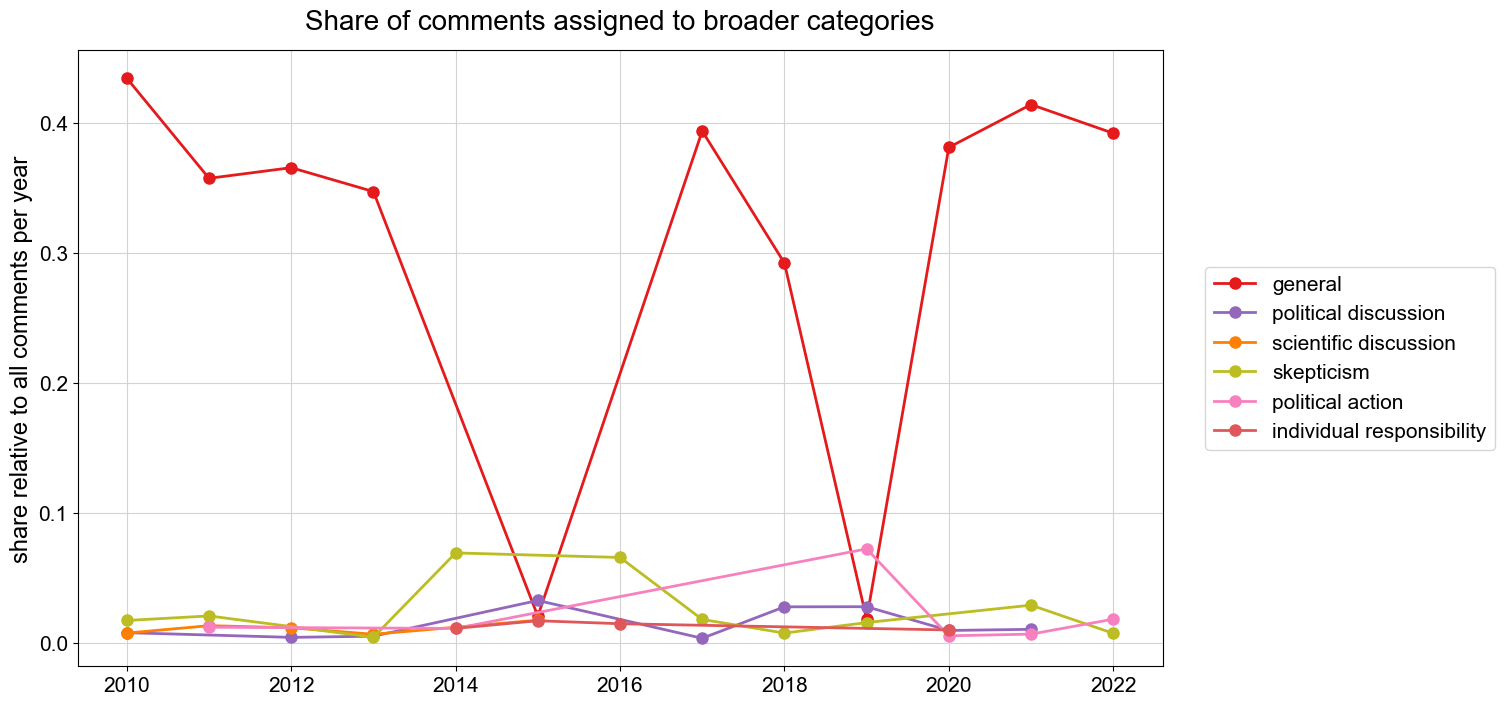

In [10]:
plt.rc('font', size=15)
plt.rcParams["figure.figsize"] = (14,8)

plt.figure(facecolor='white')
for idx, category in enumerate(aggr_df.category.unique()):
    sample = aggr_df[aggr_df.category == category]
    plt.plot(sample.year, sample.share, marker="o", linestyle="-", linewidth=2, markersize=8, label=category, c=custom_colors[idx])

plt.legend(loc="center left", bbox_to_anchor=(1.03, 0.5))
plt.title("Share of comments assigned to broader categories", size=20, pad=15)
plt.ylabel("share relative to all comments per year", size=17)
plt.grid(color="lightgrey")
plt.show()

### Without category "general"

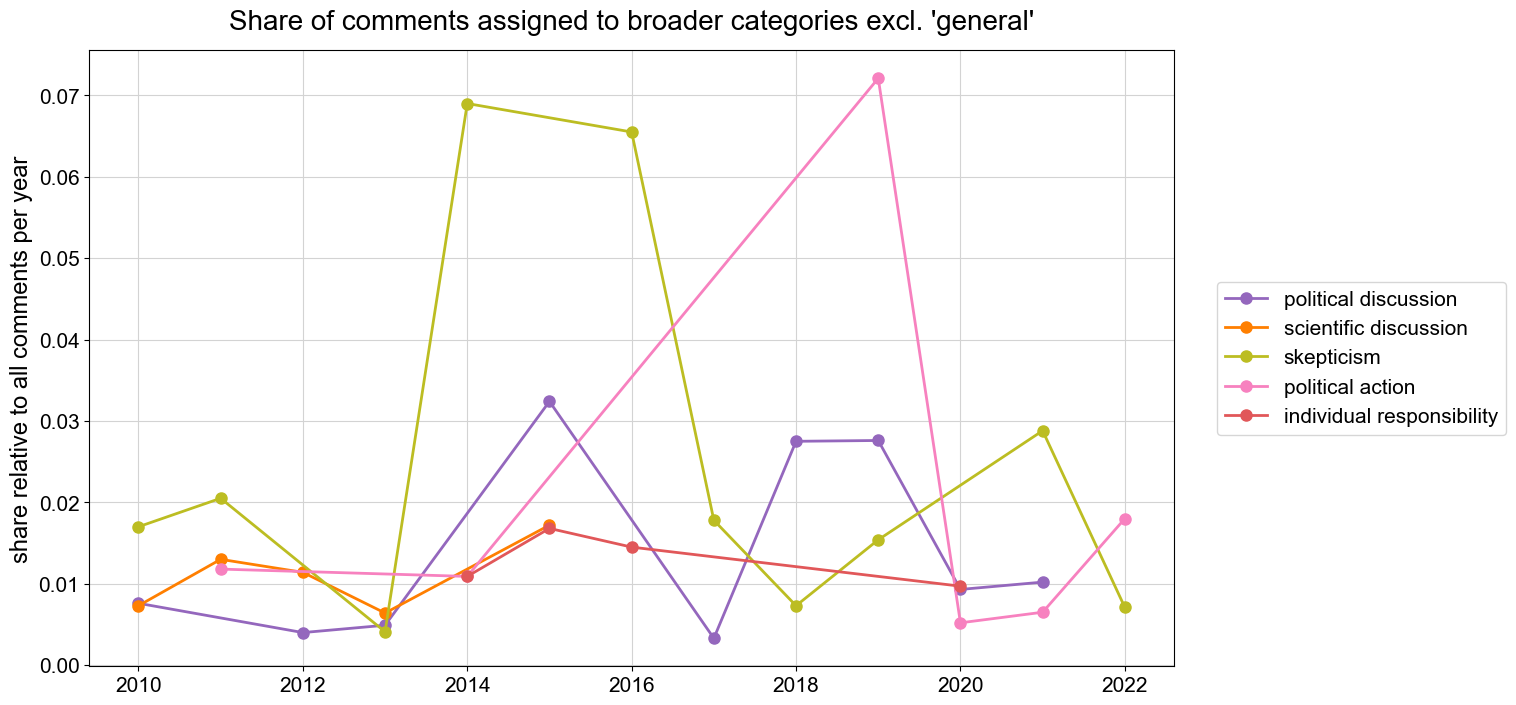

In [12]:
plt.rc('font', size=15)
plt.rcParams["figure.figsize"] = (14,8)

plt.figure(facecolor='white')
for idx, category in enumerate(aggr_df.category.unique()):
    if category != "general":
        sample = aggr_df[aggr_df.category == category]
        plt.plot(sample.year, sample.share, marker="o", linestyle="-", linewidth=2, markersize=8, label=category, c=custom_colors[idx])

plt.legend(loc="center left", bbox_to_anchor=(1.03, 0.5))
plt.title("Share of comments assigned to broader categories excl. 'general'", size=20, pad=15)
plt.ylabel("share relative to all comments per year", size=17)
plt.grid(color="lightgrey")
plt.show()

### Relative to comments per year that are not categorized as "general"

In [80]:
aggr_df

,year,category,share
0,2010,general,0.4343
1,2010,political discussion,0.0076
2,2010,scientific discussion,0.0073
3,2010,skepticism,0.0170
4,2011,general,0.3573
5,2011,political action,0.0118
6,2011,scientific discussion,0.0130
7,2011,skepticism,0.0205
8,2012,general,0.3655
9,2012,political discussion,0.0040


In [106]:
# calculate new percentages
aggr_df_balanced = pd.DataFrame(columns = ["year", "category", "share"])

for idx, year in enumerate(aggr_df.year.unique()):
    df_year = aggr_df[aggr_df.year == year]
    sum_perc = 0
    for i, row in df_year.iterrows():
        sum_perc = sum_perc + row.share
    for i, row in df_year.iterrows():
        df_year.at[i, 'share'] = row.share/sum_perc
    aggr_df_balanced = pd.concat([aggr_df_balanced, df_year])
        
aggr_df_balanced

,year,category,share
0,2010,general,0.931574
1,2010,political discussion,0.016302
2,2010,scientific discussion,0.015659
3,2010,skepticism,0.036465
4,2011,general,0.887481
5,2011,political action,0.029309
6,2011,scientific discussion,0.032290
7,2011,skepticism,0.050919
8,2012,general,0.959569
9,2012,political discussion,0.010501


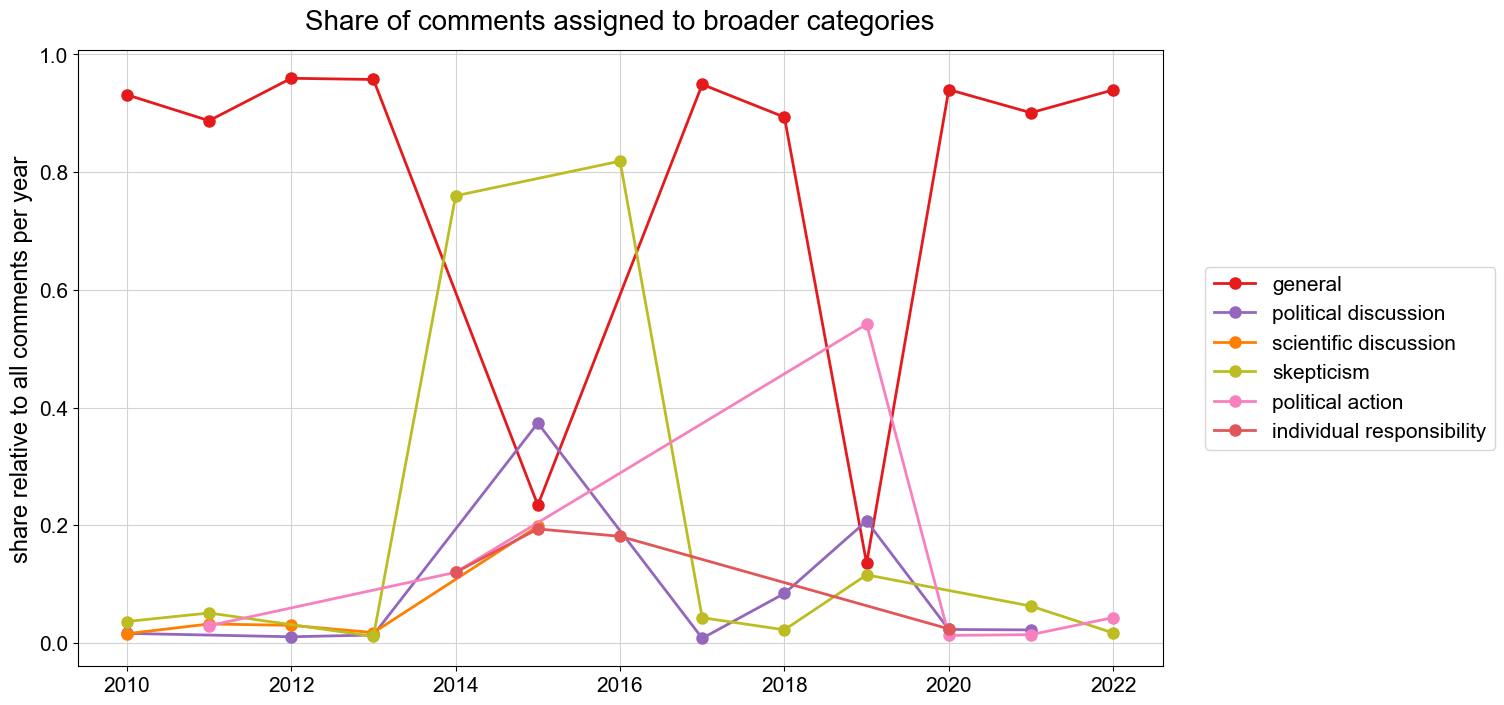

In [107]:
plt.rc('font', size=15)
plt.rcParams["figure.figsize"] = (14,8)

plt.figure(facecolor='white')
for idx, category in enumerate(aggr_df.category.unique()):
    sample = aggr_df_balanced[aggr_df_balanced.category == category]
    plt.plot(sample.year, sample.share, marker="o", linestyle="-", linewidth=2, markersize=8, label=category, c=custom_colors[idx])

plt.legend(loc="center left", bbox_to_anchor=(1.03, 0.5))
plt.title("Share of comments assigned to broader categories", size=20, pad=15)
plt.ylabel("share relative to all comments per year", size=17)
plt.grid(color="lightgrey")
plt.show()

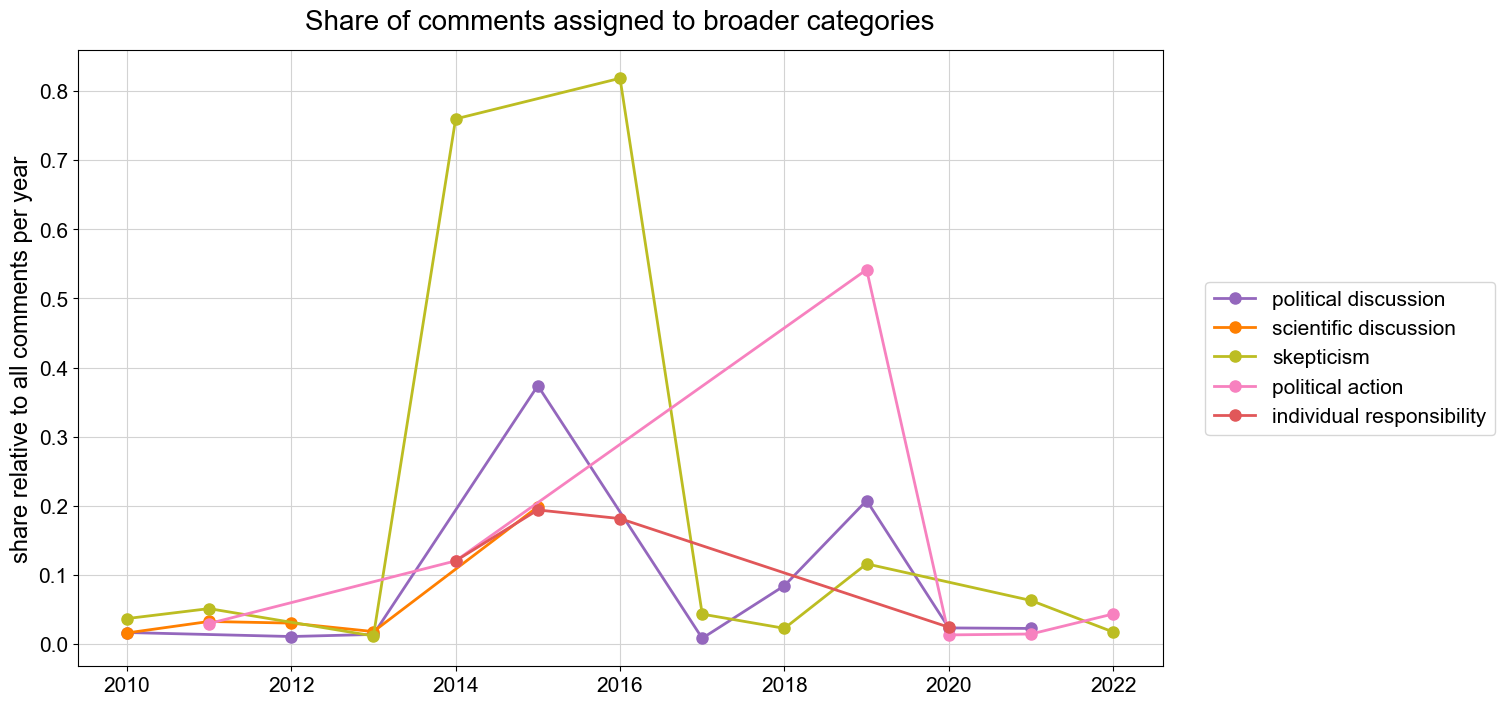

In [108]:
plt.rc('font', size=15)
plt.rcParams["figure.figsize"] = (14,8)

plt.figure(facecolor='white')
for idx, category in enumerate(aggr_df_balanced.category.unique()):
    if category != "general":
        sample = aggr_df_balanced[aggr_df_balanced.category == category]
        plt.plot(sample.year, sample.share, marker="o", linestyle="-", linewidth=2, markersize=8, label=category, c=custom_colors[idx])

plt.legend(loc="center left", bbox_to_anchor=(1.03, 0.5))
plt.title("Share of comments assigned to broader categories", size=20, pad=15)
plt.ylabel("share relative to all comments per year", size=17)
plt.grid(color="lightgrey")
plt.show()

In [15]:
# calculate new percentages
aggr_df_balanced_ex_gen = pd.DataFrame(columns = ["year", "category", "share"])

for idx, year in enumerate(aggr_df.year.unique()):
    df_year = aggr_df[aggr_df.year == year]
    sum_perc = 0
    for i, row in df_year.iterrows():
        if row.category != "general":
            sum_perc = sum_perc + row.share
    for i, row in df_year.iterrows():
        df_year.at[i, 'share'] = row.share/sum_perc
    aggr_df_balanced_ex_gen = pd.concat([aggr_df_balanced_ex_gen, df_year])
        
aggr_df_balanced_ex_gen

,year,category,share
0,2010,general,13.614420
1,2010,political discussion,0.238245
2,2010,scientific discussion,0.228840
3,2010,skepticism,0.532915
4,2011,general,7.887417
5,2011,political action,0.260486
6,2011,scientific discussion,0.286976
7,2011,skepticism,0.452539
8,2012,general,23.733766
9,2012,political discussion,0.259740


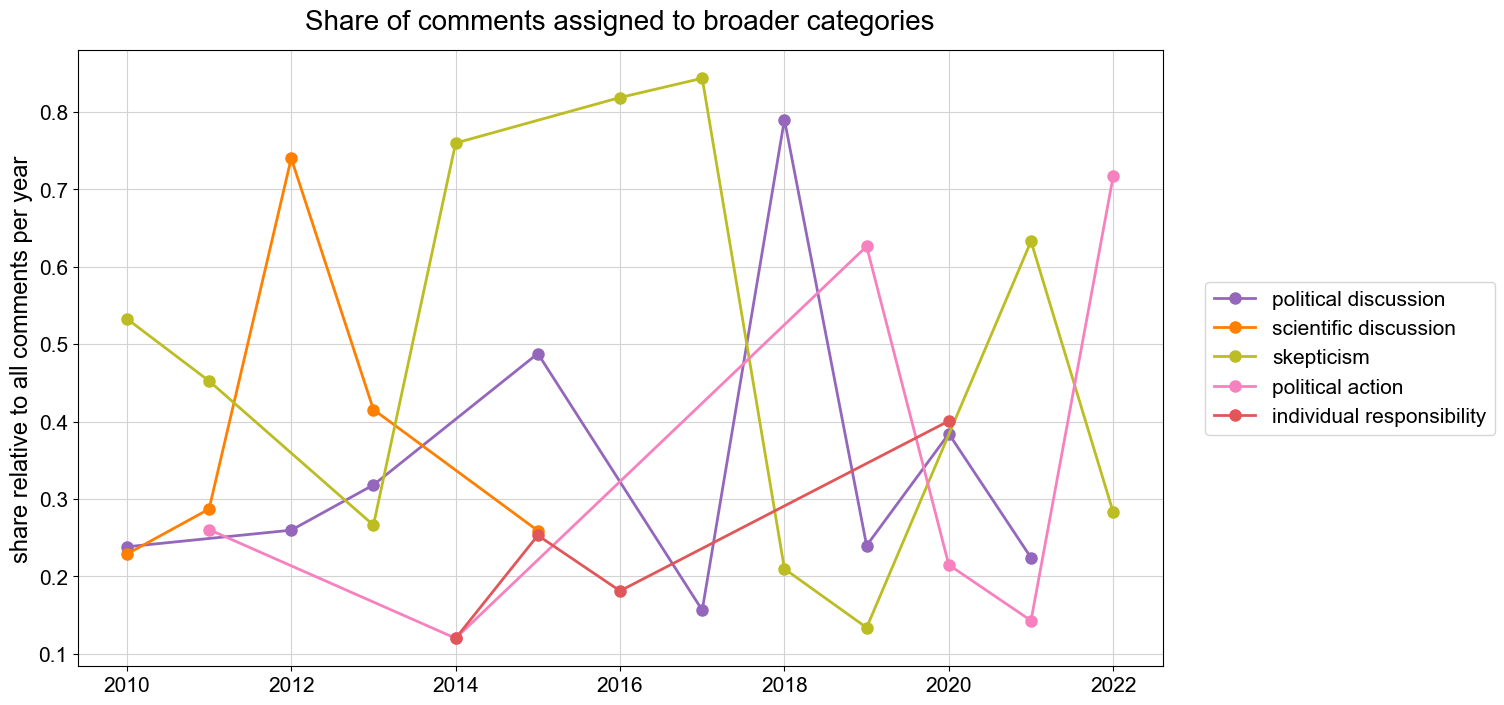

In [16]:
plt.rc('font', size=15)
plt.rcParams["figure.figsize"] = (14,8)

plt.figure(facecolor='white')
for idx, category in enumerate(aggr_df_balanced_ex_gen.category.unique()):
    if category != "general":
        sample = aggr_df_balanced_ex_gen[aggr_df_balanced_ex_gen.category == category]
        plt.plot(sample.year, sample.share, marker="o", linestyle="-", linewidth=2, markersize=8, label=category, c=custom_colors[idx])

plt.legend(loc="center left", bbox_to_anchor=(1.03, 0.5))
plt.title("Share of comments assigned to broader categories", size=20, pad=15)
plt.ylabel("share relative to all comments per year", size=17)
plt.grid(color="lightgrey")
plt.show()